# ML Project---- Call type classification with structured data
Wenkai Xu

# Introduction:
In my country, China,  people call 119 fire police when facing a structure fire; people call 120 for medical incidents; people call 110 when illegal issues happen; etc... Different departments handle different incidents separately. In the State, it is a totally different situation and I wonder how it works and is there any underlying pattern so that we can predict the call type (for example in some certain district, medical incident is often called, which mean there might be a hospital around the area; in some certain district, water rescue is often called, which mean there's a dangerous water area). I tried to build a model to answer the questions.

In this project, I will use San Francisco Fire Department Service Calls Data from Google Big Query as my dataset to analyze. I will predict call_type such as Water Rescue, Structure Fire, Medical Incident,etc.. After observing the dataset, I found out the top 3 call types are "Medical Incident","Structure Fire" and "Alarms" so that I decided to build 3 main classifiers(Medical, Alarm, Fire) at first. Later I want to inclue "Traffic Collision", "Water Rescue" and "Others" as other 3 classifiers. Thus, now I have 6 classifiers and I will use ML Workbench to create a classification model. BTW, "Fire" classifier includes Structure Fire, Outside Fire and Vehicle Fire. "Others" includes everything except other call_types listed above. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import google.datalab.bigquery as bq

# Data Exploration

Here is the original data stored as a BigQuery public dataset. See Table bigquery-public-data:san_francisco.sffd_service_calls for more details.

In [2]:
air = bq.Query('SELECT * FROM `bigquery-public-data.san_francisco.sffd_service_calls` LIMIT 10 ')
df = air.execute(output_options=bq.QueryOutput.dataframe()).result()
df.head(10)

,call_number,unit_id,incident_number,call_type,call_date,watch_date,received_timestamp,entry_timestamp,dispatch_timestamp,response_timestamp,...,number_of_alarms,unit_type,unit_sequence_in_call_dispatch,fire_prevention_district,supervisor_district,neighborhood_district,location,row_id,latitude,longitude
0,42330014,AR1,4064337,Structure Fire,2004-08-20,2004-08-19,2004-08-20 00:51:57,2004-08-20 00:52:06,2004-08-20 00:52:21,NaT,...,1,INVESTIGATION,13,10,10,,"(37.7543700441294, -122.403998489901)",042330014-AR1,37.754370,-122.403998
1,42660005,BE1,4073628,Other,2004-09-22,2004-09-21,2004-09-22 00:18:12,2004-09-22 00:18:27,2004-09-22 00:18:34,2004-09-22 00:20:54,...,1,SUPPORT,1,4,3,,"(37.7895863090063, -122.417042490532)",042660005-BE1,37.789586,-122.417042
2,42480137,BE1,4068548,Other,2004-09-04,2004-09-04,2004-09-04 10:04:41,2004-09-04 10:04:53,2004-09-04 10:04:59,NaT,...,1,SUPPORT,1,2,10,,"(37.7659581887586, -122.404623338223)",042480137-BE1,37.765958,-122.404623
3,171132450,FB1,17048282,Water Rescue,2017-04-23,2017-04-23,2017-04-23 16:23:51,2017-04-23 16:25:02,2017-04-23 16:27:17,2017-04-23 16:29:46,...,1,SUPPORT,6,3,6,,"(37.7699239665163, -122.386304082705)",171132450-FB1,37.769924,-122.386304
4,2200208,RA13,65821,Medical Incident,2000-08-07,2000-08-07,2000-08-07 16:51:14,2000-08-07 16:55:07,2000-08-07 16:57:53,2000-08-07 17:00:37,...,1,AIRPORT,1,2,6,,"(37.7765219497633, -122.409677685594)",002200208-RA13,37.776522,-122.409678
5,2850286,RA32,85635,Medical Incident,2000-10-11,2000-10-11,2000-10-11 22:30:23,2000-10-11 22:30:47,2000-10-11 22:32:32,2000-10-11 22:33:49,...,1,AIRPORT,1,3,6,,"(37.7785992634984, -122.408503211368)",002850286-RA32,37.778599,-122.408503
6,2780205,RA38,83533,Medical Incident,2000-10-04,2000-10-04,2000-10-04 17:51:12,2000-10-04 17:52:22,2000-10-04 17:56:24,2000-10-04 17:56:59,...,1,AIRPORT,1,3,6,,"(37.7746534767072, -122.405118197249)",002780205-RA38,37.774653,-122.405118
7,3210288,RA29,96138,Medical Incident,2000-11-16,2000-11-16,2000-11-16 22:24:06,2000-11-16 22:24:29,2000-11-16 22:24:43,2000-11-16 22:26:09,...,1,AIRPORT,1,2,6,,"(37.7763059521196, -122.407289659071)",003210288-RA29,37.776306,-122.407290
8,10090079,RA29,1002725,Medical Incident,2001-01-09,2001-01-09,2001-01-09 08:26:35,2001-01-09 08:27:54,2001-01-09 08:28:28,2001-01-09 08:33:03,...,1,AIRPORT,1,3,6,,"(37.775420706711, -122.403404791479)",010090079-RA29,37.775421,-122.403405
9,2540327,RA32,76311,Medical Incident,2000-09-10,2000-09-10,2000-09-10 23:53:19,2000-09-10 23:53:49,2000-09-10 23:54:09,NaT,...,1,AIRPORT,7,2,6,,"(37.7715786771769, -122.411277938324)",002540327-RA32,37.771579,-122.411278


# Here is the schema for the attributes:

In [3]:
%%bq tables describe
name: bigquery-public-data.san_francisco.sffd_service_calls

Many of the attributes are redundant, for example we have latitude and longitude so I decide to drop location; we have box address so I dropped the district-related attributes. "Address" is a text feature (not categorical) because of the large unique values size. "Unit_type", "priority", "call_final_disposition" and etc.. are categorical columns. At last, I have converted "timestamp" into weekday, day_in_year, hours to make them more meaningful.

# Here is the total counts:

In [4]:
%%bq query

select count(*) from `bigquery-public-data.san_francisco.sffd_service_calls`

f0_
4513036


From the table above, we can see that the top 4 attributes are 	Medical Incident, Structure Fire, Alarms and Traffic Collision.
I made 6 classifiers as following: Medical, Alarm, Fire, Traffic Collision, Water Rescue and Others.

# Data Prep

I select the features from source table, sample it (to fit local run), split it into train/eval set, and also do some feature extraction.

In [5]:
%%bq query --name calls
SELECT
  call_number,
  unit_type,
  unit_id, 
  box,
  priority,
  address,
  call_type_group,
  call_final_disposition,
  number_of_alarms,
  CASE WHEN call_type='Medical Incident'  Then 'Medical' WHEN call_type='Alarms' Then 'Alarm' WHEN (call_type='Structure Fire' or call_type='Vehicle Fire' or call_type="Outside Fire") Then 'Fire' When call_type="Traffic Collision" Then "Traffic Collision" When call_type="Water Rescue" Then "Water Rescue" else 'Others' END as call_type, 
  longitude,
  latitude,
  CAST(EXTRACT(HOUR FROM received_timestamp) AS STRING) as hour,
  CAST(EXTRACT(DAYOFWEEK FROM received_timestamp) AS STRING) as weekday,
  CAST(EXTRACT(DAYOFYEAR FROM received_timestamp) AS STRING) as day
FROM `bigquery-public-data.san_francisco.sffd_service_calls`



I sample 3% data, and split it into train/eval set.



In [6]:
import google.datalab.bigquery as bq
import numpy as np

sampling = bq.Sampling.random(percent=3)
job = calls.execute(sampling=sampling)
result = job.result()
data_schema = result.schema
df = result.to_dataframe()

msk = np.random.rand(len(df)) < 0.9
train_df = df[msk]
eval_df = df[~msk]

In [7]:
print('Training set includes %d instances.' % len(train_df))
print('Eval set includes %d instances.' % len(eval_df))

Training set includes 121942 instances.
Eval set includes 13461 instances.


In [8]:
!mkdir -p ./calls

In [9]:
train_df.to_csv('./calls/train.csv', header=False, index=False)
eval_df.to_csv('./calls/eval.csv', header=False, index=False)

# Building Model 

I am following the model building steps--- Analysis, Transform, Training, Evaluation.

In [10]:
import google.datalab.contrib.mlworkbench.commands

# Creating Model with ML Workbench locally

In [11]:
%%ml dataset create
format: csv
train: ./calls/train.csv
eval: ./calls/eval.csv
name: calls_3pcnt
schema: $data_schema

In [12]:
!rm -r -f ./calls/analysis

# Step 1: Analyze

In [13]:
%%ml analyze
output: ./calls/analysis
data: calls_3pcnt
features:
  call_number:
    transform: key
  unit_type:
    transform: one_hot         
  unit_id:
    transform: one_hot 
  box:
    transform: one_hot
  priority:
    transform: one_hot
  address:
    transform: bag_of_words
  call_type_group:
    transform: one_hot
  call_final_disposition:
    transform: one_hot  
  number_of_alarms:
    transform: scale 
  call_type:
    transform: target 
  longitude:
    transform: scale
  latitude:
    transform: scale
  hour:
    transform: one_hot
  weekday:
    transform: one_hot
  day:
    transform: one_hot

Expanding any file patterns...
file list computed.
Analyzing file /content/datalab/calls/train.csv...
file /content/datalab/calls/train.csv analyzed.


The following attributes number of alarms, longitude and latitude are integers so that I have them transformed into scale. Call-type is the target and call_number is the primary key. The remaining attributes are strings and are transformed into one_hot.

In [14]:
!rm -r -f ./calls/transform

# Step 2: Transform

In [15]:
%%ml transform
output: ./calls/transform
analysis: ./calls/analysis
shuffle: true
data: calls_3pcnt

/usr/local/lib/python2.7/dist-packages/apache_beam/coders/typecoders.py:135: UserWarning: Using fallback coder for typehint: Any.
  warnings.warn('Using fallback coder for typehint: %r.' % typehint)
/usr/local/lib/python2.7/dist-packages/apache_beam/coders/typecoders.py:135: UserWarning: Using fallback coder for typehint: Any.
  warnings.warn('Using fallback coder for typehint: %r.' % typehint)


In [16]:
%%ml dataset create
format: transformed
name: calls_3pcnt_transformed
train: ./calls/transform/train-*
eval: ./calls/transform/eval-*

In [17]:
%%ml dataset explore
name: calls_3pcnt_transformed

train data instances: 121942
eval data instances: 13461


# Step 3: Training

In [18]:
!rm -r -f ./calls/train

In [22]:
%%ml train
output: ./calls/train
analysis: ./calls/analysis
data: calls_3pcnt_transformed
model_args:
    model: dnn_classification
    hidden-layer-size1: 200

TensorBoard was started successfully with pid 15898. Click here to access it.

In the training process, I have chosen only #1 layer and #200 nodes because my dataset is about 1.5G, if I built other layers or add too many nodes, it will be too slow. However, the lack of layers and nodes might reduce my model's accuracy.

# Step 4: Evaluation using batch prediction

In [23]:
!rm -r -f ./calls/batch_predict # Delete previous results.

In [24]:
%%ml batch_predict
model: ./calls/train/evaluation_model/
output: ./calls/evaluation
format: csv
data:
  csv: ./calls/eval.csv

local prediction...
INFO:tensorflow:Restoring parameters from ./calls/train/evaluation_model/variables/variables
done.


# Confusion_matrix

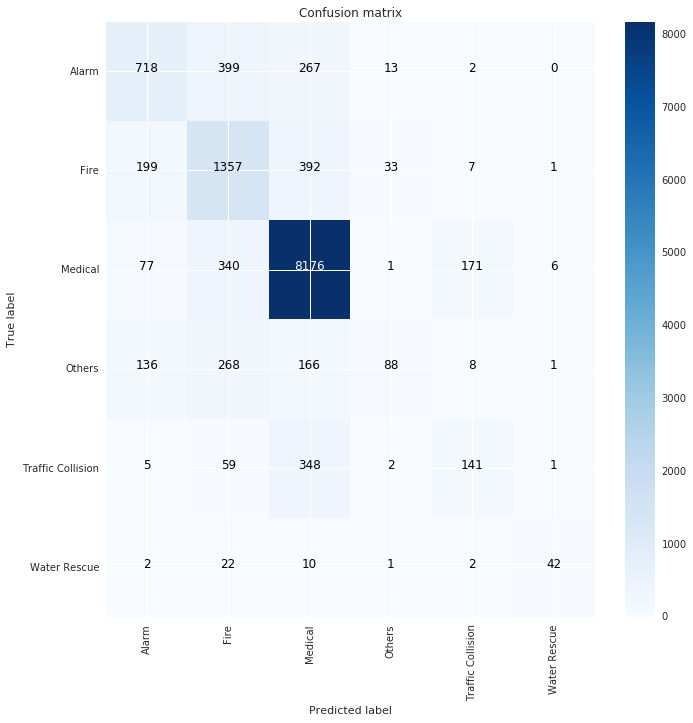

In [25]:
%%ml evaluate confusion_matrix --plot
csv: ./calls/evaluation/predict_results_eval.csv

Looking at the confusion_matrix, the overall accuracy is quite acceptable. However, many "Traffic Collision" turns out to be classified as "Medical" so it has pretty low accuracy. For the "Medical" part, my model predicts pretty well with high accuracy but some other classes are often recognized as it. I think in real life, sometimes when traffic collision happens, medical help and traffic collision are always called simultaneously. It is very hard to distinguish these two.

# Evaluating Accuracy

In [26]:
%%ml evaluate accuracy
csv: ./calls/evaluation/predict_results_eval.csv

,accuracy,count,target
0,0.513224,1399,Alarm
1,0.682252,1989,Fire
2,0.932163,8771,Medical
3,0.131934,667,Others
4,0.253597,556,Traffic Collision
5,0.531646,79,Water Rescue
6,0.781666,13461,_all


The overall accuracy is 78.16%. The highest is Medical and the lowest two is others and traffic collision.

# Explain the Model

In [28]:
%%ml predict
model: ./calls/train/model
data:
    - 12990296,CHIEF,B06,6621,3,0 Block of CARPENTER CT,,Other,1,-122.384990412,37.7348224938,16,6,299
    - 111590211,TRUCK,T15,8777,3,200 Block of LAKE MERCED HILL ST,,Other,1,-122.483644014,37.7130437838,14,4,159
    - 170070551,MEDIC,62,9944,2,100 Block of 3RD ST,Non Life-threatening,Code 2 Transport,1,-122.401709046,37.7860778017,6,7,7
    - 171293056,TRUCK,T19,8772,3,500 Block of SKYLINE BLVD,Fire,Patient Declined Transport,1,-122.501720823,37.7220782881,17,3,129

call_number,predicted,probability,address,box,call_final_disposition,call_type_group,day,hour,latitude,longitude,number_of_alarms,priority,unit_id,unit_type,weekday
12990296,Fire,0.715706,0 Block of CARPENTER CT,6621,Other,,299,16,37.7348224938,-122.384990412,1,3,B06,CHIEF,6
111590211,Alarm,0.568872,200 Block of LAKE MERCED HILL ST,8777,Other,,159,14,37.7130437838,-122.483644014,1,3,T15,TRUCK,4
170070551,Medical,0.846294,100 Block of 3RD ST,9944,Code 2 Transport,Non Life-threatening,7,6,37.7860778017,-122.401709046,1,2,62,MEDIC,7
171293056,Water Rescue,0.997784,500 Block of SKYLINE BLVD,8772,Patient Declined Transport,Fire,129,17,37.7220782881,-122.501720823,1,3,T19,TRUCK,3


These four are predicted correctly. Fire, Alarm, Water Rescue and Medical are classified with high accuracy.

In [29]:
%%ml predict
model: ./calls/train/model
data:    
    - 70480334,TRUCK,T19,8751,3,19TH AV/HOLLOWAY AV,,Other,1,-122.47522195,37.721057297,18,7,48 
    - 102630072,MEDIC,86,6322,1,BOWDOIN ST/MANSELL ST,,Code 2 Transport,1,-122.407976928,37.7197360013,8,2,263

call_number,predicted,probability,address,box,call_final_disposition,call_type_group,day,hour,latitude,longitude,number_of_alarms,priority,unit_id,unit_type,weekday
70480334,Fire,0.756857,19TH AV/HOLLOWAY AV,8751,Other,,48,18,37.721057297,-122.47522195,1,3,T19,TRUCK,7
102630072,Medical,0.784687,BOWDOIN ST/MANSELL ST,6322,Code 2 Transport,,263,8,37.7197360013,-122.407976928,1,1,86,MEDIC,2


For these two, they are predicted with errors. The first one should be classified as "Others" and the second one should be in "Traffic Collision" category. My model fails to predict "Other" and "Traffic Collision" with high accuracy. Just as Confusion_matrix has shown, Traffic Collision is mis-classified into Medical category.

# Conclusion

I think the overall model is pretty good. If we know the box address, the exact time and numbers of calls, the unit type, 
and the urgency level, my model can predict the type of calls with confidence.